**Mount Google drive if you are using google colab**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Change current working directory to project folder**

In [43]:
import os
os.chdir('/content/drive/My Drive/Project 1/')

In [44]:
DATA_FOLDER = "/content/drive/My Drive/Project 1/"

**Load the "images.npy" file**

In [45]:
import numpy as np
data = np.load(DATA_FOLDER+"images.npy",allow_pickle=True)
#allow_pickle : Allow loading pickled object arrays stored in npy files

**Checking the sample image from the loaded "images.npy" file**

In [46]:
for key in data:
    print (key)
    print (data[10][1])
    break

[array([[[42, 37, 34],
         [56, 51, 48],
         [71, 66, 63],
         ...,
         [23, 33, 34],
         [26, 36, 37],
         [28, 38, 39]],

        [[40, 35, 32],
         [51, 46, 43],
         [64, 59, 56],
         ...,
         [27, 36, 35],
         [24, 33, 32],
         [26, 35, 34]],

        [[43, 38, 35],
         [51, 46, 43],
         [61, 56, 53],
         ...,
         [28, 30, 27],
         [33, 35, 32],
         [35, 37, 34]],

        ...,

        [[56, 47, 40],
         [57, 48, 41],
         [61, 52, 45],
         ...,
         [67, 48, 42],
         [55, 35, 28],
         [60, 40, 33]],

        [[53, 44, 37],
         [54, 45, 38],
         [57, 48, 41],
         ...,
         [59, 40, 34],
         [60, 40, 33],
         [54, 34, 27]],

        [[53, 44, 37],
         [54, 45, 38],
         [57, 48, 41],
         ...,
         [59, 40, 34],
         [70, 50, 43],
         [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points':

**Set image dimensions**

In [47]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224 

**Creating features and labels**

In [48]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**Checking the shape of X_train and mask array**

In [49]:
X_train.shape

(409, 224, 224, 3)

In [50]:
masks.shape

(409, 224, 224)

**Printing a prediction image and image array**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.45882356  0.47450984  0.57647061]
  [ 0.45882356  0.47450984  0.57647061]
  [ 0.47450984  0.49019611  0.59215689]
  ...
  [-0.72549021 -0.49803919 -0.16862744]
  [-0.75686276 -0.48235291 -0.30196077]
  [-0.74117649 -0.47450978 -0.27843136]]

 [[ 0.49803925  0.52941179  0.62352943]
  [ 0.49803925  0.52941179  0.62352943]
  [ 0.52941179  0.56078434  0.65490198]
  ...
  [-0.74901962 -0.52156866 -0.21568626]
  [-0.65490198 -0.38823527 -0.17647058]
  [-0.67058825 -0.40392154 -0.18431371]]

 [[ 0.44313729  0.47450984  0.56862748]
  [ 0.36470592  0.39607847  0.49019611]
  [ 0.41960788  0.45098042  0.54509807]
  ...
  [-0.65490198 -0.41960782 -0.13725489]
  [-0.84313726 -0.58431375 -0.32549018]
  [-0.85882354 -0.60000002 -0.34117645]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

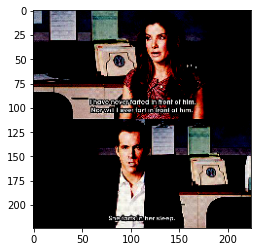

In [51]:
from matplotlib import pyplot
n = 5
print(X_train[n])
print(type(X_train[n]))
pyplot.imshow(X_train[n])

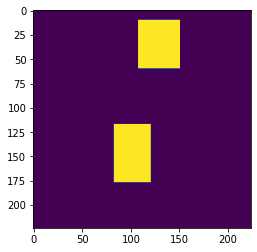

In [52]:
pyplot.imshow(masks[n])

**Creating the model**

In [53]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top=False,weights='imagenet',alpha=1.0) # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    return Model(inputs=model.input, outputs=x)

**Model Summary**

In [54]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

**Defining dice coefficient function**

In [55]:
from keras import backend as K
import numpy as np

In [56]:
def dice_coefficient(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

**Defining the loss**

In [57]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**Compiling the model**

In [58]:
model.compile(loss=loss, optimizer="adam", metrics=[dice_coefficient])

**Defining checkpoint and earlystopping**

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

**Fitting the Model**

In [60]:
model.fit(X_train,masks,
            epochs=20,batch_size = 1,callbacks=[checkpoint, reduce_lr, stop],
            verbose=1)

Epoch 1/20
409/409 [==============================] - ETA: 0s - loss: 1.1731 - dice_coefficient: 0.5147
Epoch 1: loss improved from inf to 1.17308, saving model to model-1.17.h5
409/409 [==============================] - 445s 1s/step - loss: 1.1731 - dice_coefficient: 0.5147 - lr: 0.0010
Epoch 2/20
409/409 [==============================] - ETA: 0s - loss: 0.8566 - dice_coefficient: 0.5972
Epoch 2: loss improved from 1.17308 to 0.85655, saving model to model-0.86.h5
409/409 [==============================] - 440s 1s/step - loss: 0.8566 - dice_coefficient: 0.5972 - lr: 0.0010
Epoch 3/20
409/409 [==============================] - ETA: 0s - loss: 0.7284 - dice_coefficient: 0.6383
Epoch 3: loss improved from 0.85655 to 0.72836, saving model to model-0.73.h5
409/409 [==============================] - 439s 1s/step - loss: 0.7284 - dice_coefficient: 0.6383 - lr: 0.0010
Epoch 4/20
409/409 [==============================] - ETA: 0s - loss: 0.6939 - dice_coefficient: 0.6493
Epoch 4: loss improve

**Predicted the mask for the prediction image**

In [61]:
n = 5
sample_image = X_train[n]
sample_mask = masks[n]
pred_mask = model.predict(sample_image.reshape(1,sample_image.shape[0],sample_image.shape[1],sample_image.shape[2]))

**Imposing the mask on the imag**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


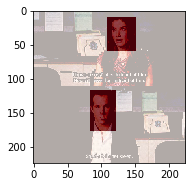

In [62]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,2)
plt.imshow(sample_image, 'Greens', interpolation = 'none')
plt.imshow(sample_mask, 'Reds', interpolation = 'none', alpha = 0.7)
plt.show()